In [113]:
import pandas as pd

import matplotlib.pyplot as plt

# Data Cleaning

Need to get rid of the unusable  and redundant columns

In [114]:
df = pd.read_csv('all_seasons.csv', index_col=0)
df.reset_index(inplace=True, drop = True)
df

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,poss_y,attendance,captain,formation,referee,match report_y,notes,team,season,xg
0,14/09/2020,20:15,Premier League,Matchweek 1,Mon,Away,W,3,1,Brighton,...,48.0,NaN,Jorginho,4-2-2-2,Craig Pawson,Match Report,NaN,Chelsea,2020-2021,NaN
1,20/09/2020,16:30,Premier League,Matchweek 2,Sun,Home,L,0,2,Liverpool,...,39.0,NaN,Jorginho,4/03/2003,Paul Tierney,Match Report,NaN,Chelsea,2020-2021,NaN
2,23/09/2020,19:45,EFL Cup,Third round,Wed,Home,W,6,0,Barnsley,...,69.0,NaN,César Azpilicueta,4-2-3-1,Darren Bond,Match Report,NaN,Chelsea,2020-2021,NaN
3,26/09/2020,17:30,Premier League,Matchweek 3,Sat,Away,D,3,3,West Brom,...,75.0,NaN,Thiago Silva,4-2-3-1,Jonathan Moss,Match Report,NaN,Chelsea,2020-2021,NaN
4,29/09/2020,19:45,EFL Cup,Fourth round,Tue,Away,D,1 (4),1 (5),Tottenham,...,63.0,NaN,César Azpilicueta,4-2-3-1,Lee Mason,Match Report,Tottenham won on penalty kicks following extra...,Chelsea,2020-2021,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4020,18/01/2023,20:00,Premiership,Regular season,Wed,Away,W,3,2,Kilmarnock,...,78.0,8461.0,James Tavernier,4-2-3-1,Kevin Clancy,Match Report,NaN,Rangers,2022-2023,NaN
4021,28/01/2023,15:00,Premiership,Regular season,Sat,Home,W,2,0,St Johnstone,...,69.0,49672.0,James Tavernier,4-2-3-1,William Collum,Match Report,NaN,Rangers,2022-2023,NaN
4022,1/02/2023,19:45,Premiership,Regular season,Wed,Away,W,3,0,Hearts,...,51.0,18330.0,James Tavernier,4-2-3-1,John Beaton,Match Report,NaN,Rangers,2022-2023,NaN
4023,4/02/2023,15:00,Premiership,Regular season,Sat,Home,W,2,1,Ross County,...,70.0,49115.0,James Tavernier,4-2-3-1,Euan Anderson,Match Report,NaN,Rangers,2022-2023,NaN


Fix the formation column after you have fixed the ML. excel overwrites the formation column with dates. 

In [115]:
cols_todel = ['ga','match report_x','match report_y','date_opp','time_opp','comp_opp','round_opp','day_opp','venue_opp','result_opp','ga_opp','opponent_opp','xg', 'match report_opp','poss_y', 'comp', 'captain','referee','notes', 'attendance','formation']
df.drop(cols_todel, axis=1, inplace=True)
df.shape

(4025, 215)

gf = gols for
ga = goals against
gf_opp = goals or the opponent
ga_opp = goals against the opponent. 

poss = possession, it has got x, y in the merging, will drop one and use the other. 

Will et rid of ga and ga_opp as the columns are redundant. 


# Making some of the string columns numerical to use them in the analysis

Some gf and gf_opp parts have "()" in them for aggregate score. I will have to ensure they are processed correctly, I will take the value outside of the parenthesis, as that is the match sore.

In [116]:
df.loc[df["gf"].str.contains(" "),'gf'] = df["gf"].str[0] # if the Score column starts with "(", then grab the first from left char.
df.loc[df["gf_opp"].str.contains(" "),'gf_opp'] = df["gf_opp"].str[0]

df.head(5)

,date,time,round,day,venue,result,gf,opponent,gls,sh,...,pkwon_opp,pkcon_opp,og_opp,recov_opp,won_opp,won%_opp,xg_y,xga,team,season
0,14/09/2020,20:15,Matchweek 1,Mon,Away,W,3,Brighton,3.0,9.0,...,0.0,1.0,0.0,54.0,10.0,43.5,1.2,1.1,Chelsea,2020-2021
1,20/09/2020,16:30,Matchweek 2,Sun,Home,L,0,Liverpool,0.0,4.0,...,0.0,1.0,0.0,53.0,3.0,21.4,0.9,2.1,Chelsea,2020-2021
2,23/09/2020,19:45,Third round,Wed,Home,W,6,Barnsley,6.0,17.0,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Chelsea,2020-2021
3,26/09/2020,17:30,Matchweek 3,Sat,Away,D,3,West Brom,3.0,22.0,...,0.0,0.0,0.0,48.0,11.0,39.3,2.0,0.6,Chelsea,2020-2021
4,29/09/2020,19:45,Fourth round,Tue,Away,D,1,Tottenham,1.0,7.0,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Chelsea,2020-2021


In [117]:
df['date'] = pd.to_datetime(df['date'],dayfirst=True)
df["venue_code"] = df["venue"].astype("category").cat.codes
df["opp_code"] = df["opponent"].astype("category").cat.codes
df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")
df["day_code"] = df["date"].dt.dayofweek
df.head()

,date,time,round,day,venue,result,gf,opponent,gls,sh,...,won_opp,won%_opp,xg_y,xga,team,season,venue_code,opp_code,hour,day_code
0,2020-09-14,20:15,Matchweek 1,Mon,Away,W,3,Brighton,3.0,9.0,...,10.0,43.5,1.2,1.1,Chelsea,2020-2021,0,66,20,0
1,2020-09-20,16:30,Matchweek 2,Sun,Home,L,0,Liverpool,0.0,4.0,...,3.0,21.4,0.9,2.1,Chelsea,2020-2021,1,217,16,6
2,2020-09-23,19:45,Third round,Wed,Home,W,6,Barnsley,6.0,17.0,...,NaN,NaN,NaN,NaN,Chelsea,2020-2021,1,45,19,2
3,2020-09-26,17:30,Matchweek 3,Sat,Away,D,3,West Brom,3.0,22.0,...,11.0,39.3,2.0,0.6,Chelsea,2020-2021,0,408,17,5
4,2020-09-29,19:45,Fourth round,Tue,Away,D,1,Tottenham,1.0,7.0,...,NaN,NaN,NaN,NaN,Chelsea,2020-2021,0,369,19,1


Deleting rows that are missing a lot of stats. Already have very high dimensionality, and not enough data or this many dimensions, so wil cull some of the stat columns. 8500 rows is nwo enough for this many columns. 

(4025, 219)

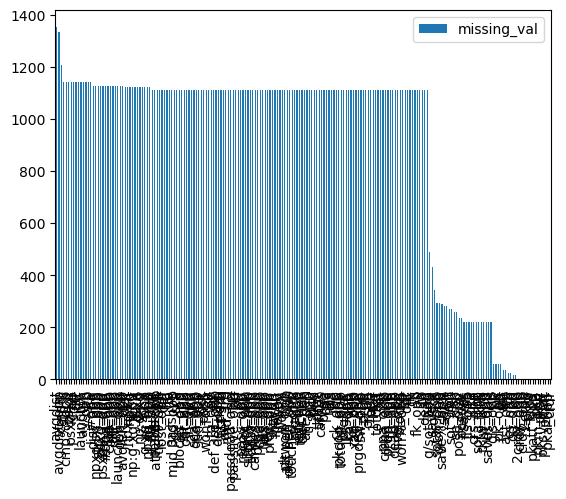

In [118]:
missing = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
missing.rename(columns={0:'missing_val'}, inplace=True)

missing[missing['missing_val']>0].plot.bar()

df.shape

We can see that the number of missing values drops down in a step function. So we delete the columns ofr missing values over 200 and the rows for anything less than that. 

In [119]:
cols_todel = missing[missing['missing_val']>300].index
df.drop(list(cols_todel), axis=1, inplace=True)
df.shape

(4025, 64)

Of course if one is interested, one can use these columns with the rows that have them, but I choose to have lower dimensionality and more data rows. 

In [120]:
df = df.dropna(axis = 0) #drop rows with missing values
# df = df.reset_index(drop=True)
df.shape # and no missing values.

(3643, 64)

Everything that has to be numeric is already numeric. Let us make a target variable first.

In [121]:
df = df.sort_values("date")
#df['season'] = df['season'].str[0:4].astype('int')
#del df['index']
df=df.reset_index(drop=True)

We will adopt win or did not win.

In [122]:
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0])

venue
Away       0.526864
Home       0.622284
Neutral    0.458333
dtype: float64

In [123]:
df.venue.value_counts() # this is not balanced. Have to drop the venues that are neutral. 

Away       1824
Home       1795
Neutral      24
Name: venue, dtype: int64

In [124]:
df = df.loc[df['venue']!='Neutral'] # dropping venue = neutral. 

In [127]:
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0]) # So 52% of the home games are won. 

venue
Away    0.526864
Home    0.622284
dtype: float64

# Setting up the target column. We want only win or did not win. 

In [129]:
df['target'] = (df['result'] == "W").astype("int")

# ML Part

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [18]:
predictors = ["venue_code", "opp_code", "hour", "day_code"]

The result column (what we are trying to predict is not balanced, ths makes sense because the teams that go into Champions league wn most of their own league teams matches. )

In [137]:
rf = RandomForestClassifier(n_estimators=500, min_samples_split=40, random_state=1, class_weight='balanced')

train = df[df['date']< "2022-04-16"] # Data in order of date use 70% for training
test = df[df['date']> "2022-04-16"]

rf.fit(train[predictors],train['target'])

predictions = rf.predict(test[predictors])

print(train.shape)
print(test.shape)

accuracy_score(test["target"],predictions)

print('accuracy_score =' ,accuracy_score(test["target"],predictions))

(2503, 65)
(1105, 65)
accuracy_score = 0.5846153846153846


In [139]:
combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,237,223
1,236,409


In [141]:
from sklearn.metrics import precision_score

precision_score(test["target"], predictions, average = None)

array([0.50105708, 0.6471519 ])

In [143]:
precision_score(test["target"], predictions, average = 'weighted')

0.5863341471598758

#### Feature engineering

In [319]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(5,closed="left").mean() # To avoid data leakage from future matches
    group[new_cols] = rolling_stats
    group = group.dropna(subset = new_cols)
    return group


In [320]:
cols = ['gls','gls_opp','gf','gf_opp','sh', 'sot','g/sh','save%_opp','tkl+int','poss_x'] # Choosing based on domain knowledge.
new_cols = [f"{c}_rolling" for c in cols] # add_rolling to column names

df_rolling = df.groupby('team').apply(lambda x: rolling_averages(x,cols,new_cols))
df_rolling = df_rolling.droplevel('team')

combined, percision, importances = make_predictions (df_rolling, predictors+new_cols)

percision

array([0.6146789 , 0.63657957])

In [321]:
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,134,306
1,84,536


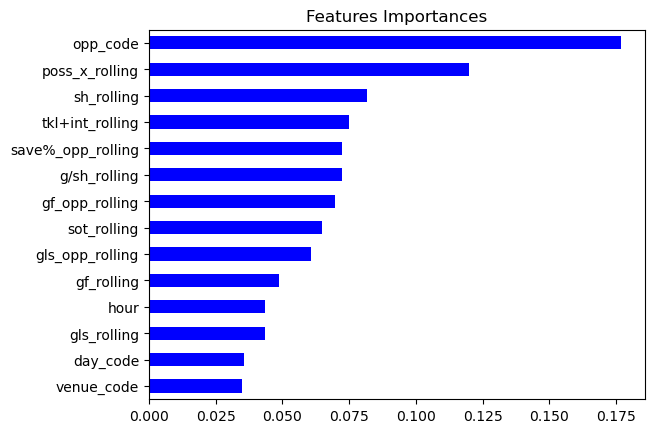

In [322]:
importance = pd.Series(data=importances,
                        index=  predictors+new_cols)
# Sort importances
importances_sorted = importance.sort_values()
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='blue')
plt.title('Features Importances')
plt.show()

# Useful stuff
then you can do the following to get a list of the numeric columns, or select an type of column based on its tpes. 

```[key for key in dict(DF.dtypes) if dict(DF.dtypes)[key] in ['float64', 'int64']]```

In [159]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit


split = TimeSeriesSplit(n_splits=3)

sfs = SequentialFeatureSelector(rf, 
                                n_features_to_select=20, 
                                direction="forward",
                                cv=split,
                                n_jobs=1
                               )

In [294]:
predictors

['venue_code', 'opp_code', 'hour', 'day_code']

In [323]:
cols = ['gf',
       'gls', 'sh', 'sot', 'sot%', 'g/sh', 'pk', 'pkatt', 'gf_opp', 'gls_opp',
       'sh_opp', 'sot_opp', 'sot%_opp', 'g/sh_opp', 'pk_opp', 'pkatt_opp',
       'sota', 'saves', 'cs', 'pka', 'pksv', 'pkm', 'sota_opp', 'saves_opp',
       'save%_opp', 'cs_opp', 'pka_opp', 'pksv_opp', 'pkm_opp', 'ast',
       'ast_opp', 'crs', 'crs_opp', 'tklw', 'int', 'tkl+int', 'tklw_opp',
       'int_opp', 'tkl+int_opp', 'poss_x', 'poss_opp', 'crdy', 'crdr', '2crdy',
       'fls', 'og', 'crdy_opp', 'crdr_opp', '2crdy_opp', 'fls_opp', 'og_opp',
       ]

new_cols = [f"{c}_rolling" for c in cols] # add_rolling to column names

df_rolling = df.groupby('team').apply(lambda x: rolling_averages(x,cols,new_cols))
df_rolling = df_rolling.droplevel('team')

In [162]:
sfs.fit(df_rolling[predictors+new_cols], df_rolling["target"])

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=RandomForestClassifier(class_weight='balanced',
                                                           min_samples_split=40,
                                                           n_estimators=500,
                                                           random_state=1),
                          n_features_to_select=20, n_jobs=1)

In [296]:
selected_cols = predictors+new_cols

In [324]:
predictors2 = [b for a, b in zip(sfs.get_support(), selected_cols) if a]

In [298]:
predictors2

['venue_code',
 'opp_code',
 'g/sh_rolling',
 'pkatt_rolling',
 'pkatt_opp_rolling',
 'pksv_rolling',
 'pkm_rolling',
 'cs_opp_rolling',
 'pksv_opp_rolling',
 'pkm_opp_rolling',
 'ast_rolling',
 'tkl+int_rolling',
 'crdy_rolling',
 'crdr_rolling',
 '2crdy_rolling',
 'og_rolling',
 'crdy_opp_rolling',
 'crdr_opp_rolling',
 '2crdy_opp_rolling',
 'og_opp_rolling']

In [325]:
predictors2=['venue_code',
 'opp_code',
 'g/sh_rolling',
 'pkatt_rolling',
 'pkatt_opp_rolling',
 'pksv_rolling',
 'pkm_rolling',
 'cs_opp_rolling',
 'pksv_opp_rolling',
 'pkm_opp_rolling',
 'ast_rolling',
 'tkl+int_rolling',
 'crdy_rolling',
 'crdr_rolling',
 '2crdy_rolling',
 'og_rolling',
 'crdy_opp_rolling',
 'crdr_opp_rolling',
 '2crdy_opp_rolling',
 'og_opp_rolling']

In [330]:
def make_predictions(data, predictors):
    rf = RandomForestClassifier(n_estimators=500, min_samples_split=2, random_state=1,  max_depth=6)

    train = data[data['date']< "2022-04-16"] # Data in order of date use 70% for training
    test = data[data['date']> "2022-04-16"]

    rf.fit(train[predictors],train['target'])

    predictions = rf.predict(test[predictors])

    combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))

    percision = precision_score(test["target"], predictions, average = 'weighted')


    return combined, percision, rf.feature_importances_

In [326]:
combined, percision, importances = make_predictions (df_rolling, predictors2)

percision

array([0.60638298, 0.62614679])

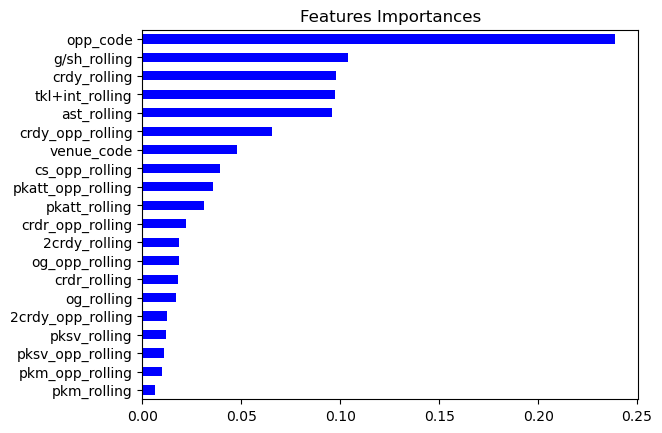

In [301]:
importance = pd.Series(data=importances,
                        index=  predictors2)
# Sort importances
importances_sorted = importance.sort_values()
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='blue')
plt.title('Features Importances')
plt.show()

In [327]:
data ={'imp_vals':importances}
imp_df = pd.DataFrame(data=data, index=predictors2)
imp_df.sort_values(by = 'imp_vals')

,imp_vals
pkm_opp_rolling,0.006979
pkm_rolling,0.007591
pksv_rolling,0.010317
2crdy_opp_rolling,0.012046
pksv_opp_rolling,0.012893
2crdy_rolling,0.015355
og_rolling,0.016183
og_opp_rolling,0.018371
crdr_rolling,0.020527
crdr_opp_rolling,0.023570


In [328]:
predictors3 = imp_df.loc[imp_df['imp_vals']>0.01].index

In [313]:
predictors3

Index(['venue_code', 'opp_code', 'g/sh_rolling', 'pkatt_rolling',
       'pkatt_opp_rolling', 'pksv_rolling', 'pkm_rolling', 'cs_opp_rolling',
       'pksv_opp_rolling', 'pkm_opp_rolling', 'ast_rolling', 'tkl+int_rolling',
       'crdy_rolling', 'crdr_rolling', '2crdy_rolling', 'og_rolling',
       'crdy_opp_rolling', 'crdr_opp_rolling', '2crdy_opp_rolling',
       'og_opp_rolling'],
      dtype='object')

In [329]:
combined, percision, importances = make_predictions (df_rolling, predictors3)

percision # Weigted

array([0.6142132 , 0.63035921])

In [331]:
combined, percision, importances = make_predictions (df_rolling, predictors3)

percision #not weighted. 

0.6236570929983108

In [248]:
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0]) # So 52% of the home games are won. 

venue
Away    0.526864
Home    0.622284
dtype: float64

Hence we have beaten the benchmark. 